In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame

try:
# Carica il tuo file XLSX
    xlsx_file = 'C:/Users/loris/Desktop/Python Workspace/FirstTryMiller/dataset/richerDataset.xlsx'  # Sostituisci con il percorso del tuo file

# Leggi i dati dal file XLSX e crea un DataFrame
    df: DataFrame = pd.read_excel(xlsx_file)

# Ora hai un DataFrame con tutti i dati dal tuo file XLSX che puoi utilizzare per l'analisi.
except FileNotFoundError as e:
    print("Il file non è stato trovato.")
# except Exception as e:
    print(f"Si è verificato un errore: {e}")                                                          
    
# Rimuovi il record con k_m2 uguale a 0
df = df[df['k_m2'] != 0]
#Rimuovi colonne Porosity tot e SSA tot
df = df.drop(['Porosity_Tot', 'SSA_Tot'], axis=1)
# Resetta gli indici del DataFrame
df.reset_index(drop=True, inplace=True)



k2_max = df['k_m2'].max()
k2_min = df['k_m2'].min()
print(df)

    Conn.Dens.  Porosity     SSA      Ech  Tortuosity          k_m2
0      310.913     0.137   5.065  -25.849      2.0340  1.473350e-12
1      310.913     0.147   5.253  -31.002      2.6650  2.254724e-12
2      310.913     0.131   4.697  -20.047      2.1090  9.543177e-12
3      350.137     0.115   5.583  -50.613      4.1830  9.664920e-13
4      350.137     0.139   7.447 -136.737      2.5950  9.180783e-13
5      350.137     0.115   5.311  -32.907      4.1010  1.435774e-12
6      368.141     0.134   6.990 -115.218      2.7740  4.010302e-13
7      368.141     0.138   7.132 -110.411      2.7790  3.937021e-12
8      368.141     0.116   5.290  -39.748      3.8680  1.933907e-12
9       10.573     0.020   0.791   -3.948      3.1000  3.021802e-13
10      10.573     0.020   0.806   -2.017      2.9000  3.190436e-13
11     458.436     0.273   7.721 -102.424      1.7170  5.516051e-11
12     458.436     0.250   6.870  -76.478      1.3530  3.822390e-11
13     458.436     0.265   7.560  -95.050      1

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df)
# Crea un nuovo DataFrame con i dati scalati e riassegna le colonne non scalate
#df_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)

# Stampa il DataFrame scalato
print("DataFrame scalato:")
print(df_scaled)

DataFrame scalato:
    Conn.Dens.  Porosity       SSA       Ech  Tortuosity      k_m2
0     0.502894  0.422383  0.449469  0.933953    0.222507  0.010982
1     0.502894  0.458484  0.469240  0.919672    0.424816  0.016905
2     0.502894  0.400722  0.410769  0.950032    0.246553  0.072152
3     0.568572  0.342960  0.503944  0.865322    0.911510  0.007140
4     0.568572  0.429603  0.699968  0.626641    0.402373  0.006773
5     0.568572  0.342960  0.475339  0.914392    0.885220  0.010697
6     0.598718  0.411552  0.651909  0.686278    0.459763  0.002854
7     0.598718  0.425993  0.666842  0.699600    0.461366  0.029657
8     0.598718  0.346570  0.473131  0.895433    0.810516  0.014473
9     0.000000  0.000000  0.000000  0.994648    0.564283  0.002104
10    0.000000  0.000000  0.001577  1.000000    0.500160  0.002232
11    0.749909  0.913357  0.728783  0.721735    0.120872  0.417936
12    0.749909  0.830325  0.639289  0.793641    0.004168  0.289555
13    0.749909  0.884477  0.711852  0.74217

In [22]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


best_y_pred = None
best_y_test = None
best_random_state_split = None
best_score_split = -float('inf')

#Dichiarazione insieme train 'X' e test 'y'
X = df_scaled.drop('k_m2', axis=1)
y = df_scaled['k_m2']
    
for random_state in range(0, 100):

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    model = XGBRegressor()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    
    if score > best_score_split:
        best_score_split = score
        best_random_state_split = random_state

print(f"Best random_state for train_test_split: {best_random_state_split} with R^2 score: {best_score_split}")



plt.figure(figsize=(7, 7))
plt.scatter(best_y_test, best_y_pred)
plt.plot([best_y_test.min(), best_y_test.max()], [best_y_test.min(), best_y_test.max()], 'k--', lw=2)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs. Predicted Values')
plt.grid(True)
plt.show()


Best random_state for train_test_split: 80 with R^2 score: 0.9973165672614642


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import logging
from tqdm.notebook import tqdm


# Configura il logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()


param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


X = df_scaled.drop('k_m2', axis=1)
y = df_scaled['k_m2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=best_random_state_split)

model = XGBRegressor(random_state=best_random_state_split)


# Personalizza GridSearchCV per utilizzare tqdm
class TQDMProgressBar(tqdm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._logger = logger

    def update_to(self, current, total):
        self.n = current
        self.total = total
        self._logger.info(f'Progress: {self.n}/{self.total} ({self.n/self.total:.2%})')
        self.refresh()

progress_bar = TQDMProgressBar(total=len(param_grid['n_estimators']) * len(param_grid['learning_rate']) * len(param_grid['max_depth']) * len(param_grid['subsample']) * len(param_grid['colsample_bytree']), desc="Hyperparameter tuning")


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=15, scoring='r2')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"R^2 score: {r2_score(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")


Hyperparameter tuning:   0%|          | 0/243 [00:00<?, ?it/s]

Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
R^2 score: 0.9988876332154237
MSE: 1.719088517215194e-05
MAE: 0.0032587216542367126


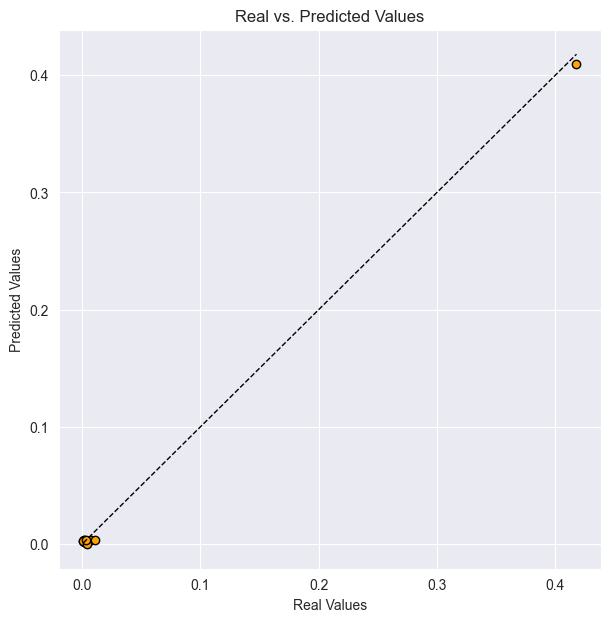

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, color='orange', alpha=0.99, edgecolors='black') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs. Predicted Values')
plt.grid(True)
plt.show()



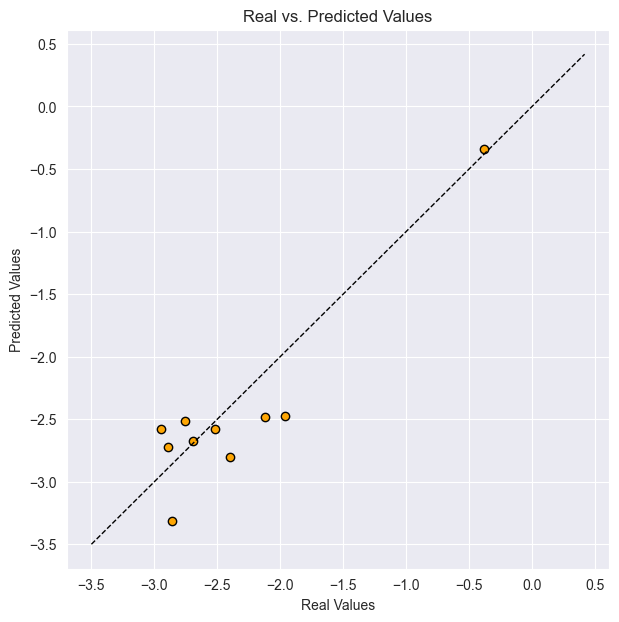

In [14]:
#Visualizzo in Log10

plt.figure(figsize=(7, 7))
plt.scatter(np.log10(y_test), np.log10(y_pred), color='orange', alpha=0.99, edgecolors='black') 
plt.plot([-3.5, y_test.max()], [-3.5, y_test.max()], 'k--', lw=1)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs. Predicted Values')
plt.grid(True)
plt.show()